In [1]:
import warnings

warnings.filterwarnings("ignore")

### Carregamento dos Dados não Tratados

In [11]:
import pandas as pd

df = pd.read_csv('../creditcard.csv')

class_label = df['Class']
df = df.drop(columns=['Class'])

In [14]:
df.shape
df[df.duplicated()].shape

(0, 30)

### Escolha do número de Cluster

In [15]:
from sklearn.cluster import KMeans
from tqdm import tqdm

k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [01:48<00:00,  5.14s/it]


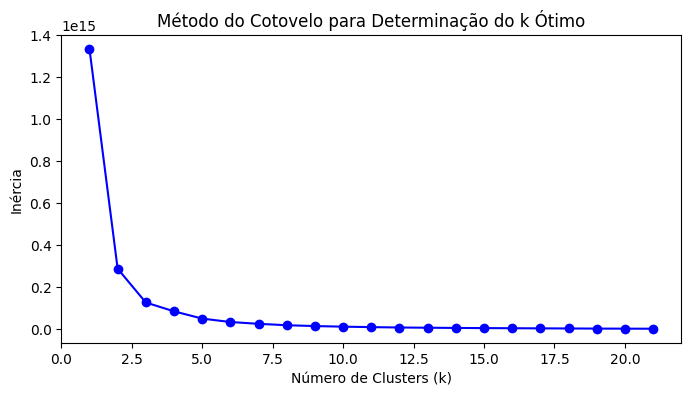

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Vamos utilizar um cálculo para podermos encontrar o valor ótimo do número de clusters. Esse cálculo pode ser encontrado nesse blog [https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9].

In [17]:
from math import sqrt

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances

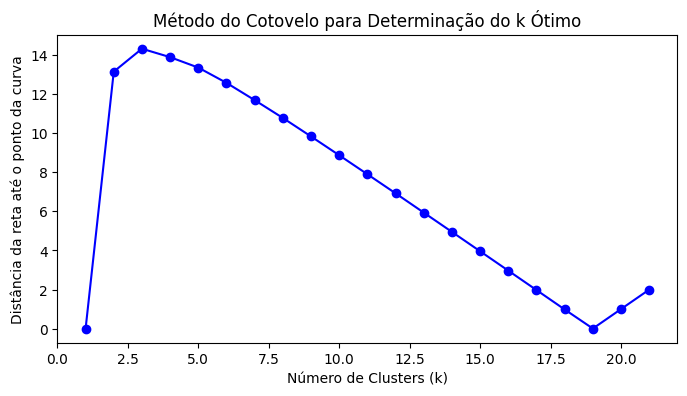

In [18]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Vemos que o número ideal de cluster, que possui o maior valor de distância entre a linha e o ponto na curva, é 3. Então podemos trabalhar com 3 clusters para os dados não tratados. Vamos agora testar os nossos hiperparâmetros (random seed) para obter um modelo mais robusto.

In [19]:
import numpy as np

# Definir o número de clusters
k = 3

# Definir o número de inicializações diferentes
num_initializations = 999

best_inertia = np.inf
best_kmeans = None
best_random_seed = None

# Treinar o modelo com diferentes random_seed
for i in tqdm(range(num_initializations)):
    random_seed = i
    kmeans = KMeans(n_clusters=k, random_state=random_seed)
    kmeans.fit(df)
    
    if kmeans.inertia_ < best_inertia:
        best_inertia = kmeans.inertia_
        best_kmeans = kmeans
        best_random_seed = random_seed

print(f"Melhor random seed: {best_random_seed}")

100%|██████████| 999/999 [32:53<00:00,  1.98s/it]

Melhor random seed: 351


Como resultado, parece que a random seed 728 possui o menor valor de inércia dentro do nosso escopo.

In [20]:
print(f"Inércia: {best_kmeans.inertia_}")

Inércia: 127339406348277.12


In [22]:
# Obter os centróides do melhor modelo
centroids = best_kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../best_centroids.csv', index=False)

In [23]:
df['cluster'] = best_kmeans.labels_
df['Class'] = class_label

df.to_csv('../creditcard_clusters.csv', index=False)

### Carregamento dos Dados Tratados

In [24]:
df = pd.read_csv('../creditcard_not_treated.csv')

class_label = df['Class']
df = df.drop(columns=['Class'])

In [25]:
df.shape

(566506, 30)

### Escolha do número de Cluster do DF tratado

In [26]:
k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


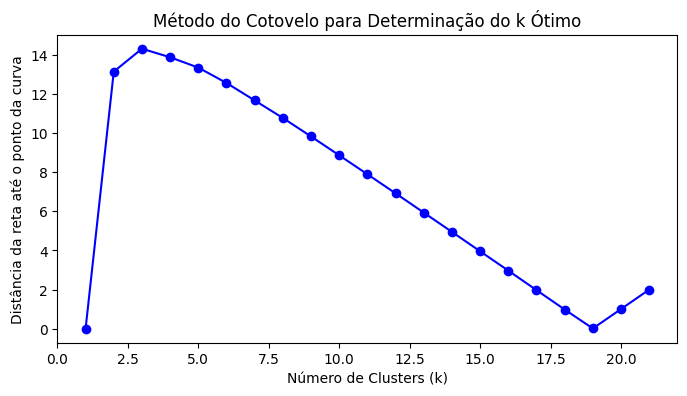

In [27]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Parece que se manteve o mesmo número ideal de clusters... Viva! E o hiperparâmetro?

In [28]:
# Definir o número de clusters
k = 3

# Definir o número de inicializações diferentes
num_initializations = 999

best_inertia = np.inf
best_kmeans = None
best_random_seed = None

# Treinar o modelo com diferentes random_seed
for i in tqdm(range(num_initializations)):
    random_seed = i
    kmeans = KMeans(n_clusters=k, random_state=random_seed)
    kmeans.fit(df)
    
    if kmeans.inertia_ < best_inertia:
        best_inertia = kmeans.inertia_
        best_kmeans = kmeans
        best_random_seed = random_seed

print(f"Melhor random seed: {best_random_seed}")

100%|██████████| 999/999 [09:34<00:00,  1.74it/s]

Melhor random seed: 434


Opa! Mudou...

In [29]:
print(f"Inércia: {best_kmeans.inertia_}")

Inércia: 127339406521014.45


A inércia está muito mais alta em comparação, o que parece fazer sentido como o volume dos dados dobrou.(SMOTE)

In [30]:
# Obter os centróides do melhor modelo
centroids = best_kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../data/best_centroids_df_treated.csv', index=False)

In [31]:
df['cluster'] = best_kmeans.labels_
df['Class'] = class_label

df.to_csv('../data/creditcard_treated_clusters.csv', index=False)

### Utilizando Autoencoders para Reduzir a dimensionalidade antes de utilizar o Kmeans

In [40]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model


df_autoencoder = pd.read_csv('../creditcard_treated.csv')

X_train, X_test = train_test_split(df_autoencoder, test_size=0.3, random_state=42)

X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=42)

input = layers.Input(shape=(X_train.shape[1],))

encoded = layers.Dense( units = 31, activation = "relu")(input)

decoded = layers.Dense( units = 31, activation = "sigmoid")(encoded)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer = "adam",loss = "binary_crossentropy", metrics = ["accuracy"])
autoencoder.summary()

autoencoder.fit(X_train, X_train, epochs = 20, batch_size = 32, validation_data = (X_test, X_test))

loss_train = autoencoder.evaluate(X_train, X_train)
loss_test = autoencoder.evaluate(X_test, X_test)
loss_val = autoencoder.evaluate(X_val, X_val)

print("Perda no conjunto de treinamento:", loss_train)
print("Perda no conjunto de validação:", loss_val)
print("Perda no conjunto de teste:", loss_test)

encoder_model = Model(input,encoded)

X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 31)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 31)             │           992 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,984 (7.75 KB)

 Trainable params: 1,984 (7.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12393/12393 ━━━━━━━━━━━━━━━━━━━━ 11s 791us/step - accuracy: 0.9227 - loss: -91702984704.0000 - val_accuracy: 1.0000 - val_loss: -717823606784.0000
Epoch 2/20
12393/12393 ━━━━━━━━━━━━━━━━━━━━ 8s 679us/step - accuracy: 1.0000 - loss: -1127025606656.0000 - val_accuracy: 1.0000 - val_loss: -2727872561152.0000
Epoch 3/20
12393/12393 ━━━━━━━━━━━━━━━━━━━━ 8s 680us/step - accuracy: 1.0000 - loss: -3484237168640.0000 - val_accuracy: 1.0000 - val_loss: -6153991880704.0000
Epoch 4/20
12393/12393 ━━━━━━━━━━━━━━━━━━━━ 8s 681us/step - accuracy: 1.0000 - loss: -7293687037952.0000 - val_accuracy: 1.0000 - val_loss: -11164308209664.0000
Epoch 5/20
12393/12393 ━━━━━━━━━━━━━━━━━━━━ 8s 672us/step - accuracy: 1.0000 - loss: -12694006530048.0000 - val_accuracy: 1.0000 - val_loss: -17769879830528.0000
Epoch 6/20
12393/12393 ━━━━━━━━━━━━━━━━━━━━ 8s 669us/step - accuracy: 1.0000 - loss: -19720535277568.0000 - val_accuracy: 1.0000 - val_loss: -26127607267328.0000
Epoch 7/20
12393/12393 ━━━━━━━━━━━━━━

Utilizando Kmeans para clusterizar os dados após reduzir sua dimensinalidade utilizando Autoencoders

In [41]:
k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_encoded)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [01:38<00:00,  4.68s/it]


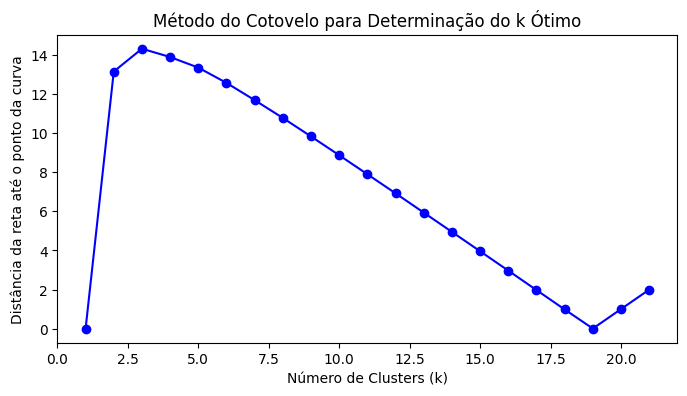

In [42]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

In [43]:
k = 3

# Definir o número de inicializações diferentes
num_initializations = 999

best_inertia = np.inf
best_kmeans = None
best_random_seed = None

# Treinar o modelo com diferentes random_seed
for i in tqdm(range(num_initializations)):
    random_seed = i
    kmeans = KMeans(n_clusters=k, random_state=random_seed)
    kmeans.fit(df)
    
    if kmeans.inertia_ < best_inertia:
        best_inertia = kmeans.inertia_
        best_kmeans = kmeans
        best_random_seed = random_seed

print(f"Melhor random seed: {best_random_seed}")

  4%|▍         | 44/999 [01:34<34:02,  2.14s/it]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "c:\Users\guilh\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 
  5%|▍         | 49/999 [01:45<36:26,  2.30s/it]

In [ ]:
print(f"Inércia: {best_kmeans.inertia_}")

In [ ]:
# Obter os centróides do melhor modelo
centroids = best_kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../data/best_centroids_df_treated.csv', index=False)

In [ ]:
df['cluster'] = best_kmeans.labels_
df['Class'] = class_label

df.to_csv('../data/creditcard_treated_clusters.csv', index=False)